#The plan for fine-tuning RoBERTa with the UCC

### 1. Set up
- Install transformers and pytorch lightning and import required packages.
- Loads UCC data and inspect it.

### 2. Create a dataset

- Load data into pytorch dataset

### 3. Build the model
 - Create a new pytorch (lightning) model with the Hugging Face RoBERTa model and a multi-label classification head.

### 4. Test model performance
- Test model performance using the ROC AUC and same test-set used in the original paper.

In [1]:
!nvidia-smi

Fri Mar 14 18:29:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [2]:
# %pip install torch --index-url https://download.pytorch.org/whl/cu121
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124%
%pip install transformers
%pip install pytorch-lightning
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install tensorboard


Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import (
    AutoModel,
    AutoTokenizer,
    get_cosine_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from typing import Optional, Dict, List

# Check versions and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU count: 1


In [4]:
train_path = 'train.csv'
val_path = 'val.csv'

In [5]:
train_data = pd.read_csv(train_path)

In [6]:
train_data.head(5)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


# inspect data

<Axes: >

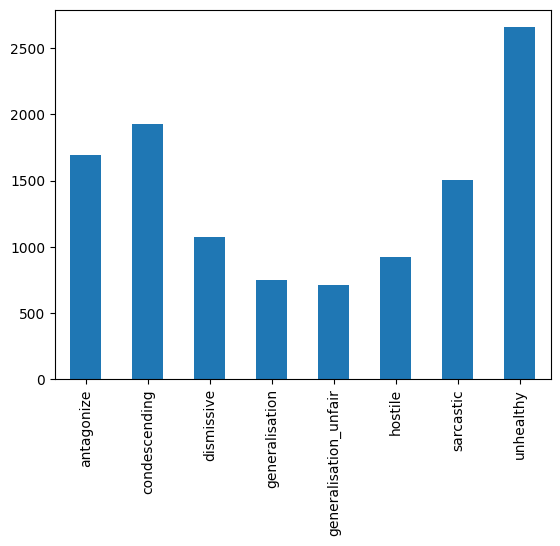

In [7]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)

attributes = ['antagonize', 'condescending','dismissive','generalisation',
              'generalisation_unfair','hostile','sarcastic','unhealthy']

train_data[attributes].sum().plot.bar()

# Dataset

In [8]:
class UCCDataset(Dataset):
    """Dataset class for Unhealthy Comment Corpus (UCC)

    Args:
        data_path (str): Path to the CSV data file
        tokenizer: HuggingFace tokenizer
        attributes (List[str]): List of target attributes to predict
        max_token_len (int): Maximum token length for padding/truncation
        sample (Optional[int]): Number of samples to use (for balanced sampling)
    """
    def __init__(
        self,
        data_path: str,
        tokenizer,
        attributes: List[str],
        max_token_len: int = 128,
        sample: Optional[int] = 5000
    ):
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.data = self._prepare_data(data_path, sample)

    def _prepare_data(self, data_path: str, sample: Optional[int]) -> pd.DataFrame:
        data = pd.read_csv(data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)

        # Convert all attribute columns to float type
        for attr in self.attributes:
            data[attr] = data[attr].astype(float)

        if sample:
            unhealthy = data[data[self.attributes].sum(axis=1) > 0]
            clean = data[data[self.attributes].sum(axis=1) == 0]
            return pd.concat([
                unhealthy,
                clean.sample(sample, random_state=42)
            ]).reset_index(drop=True)
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        row = self.data.iloc[index]

        # Encode text
        encoding = self.tokenizer(
            str(row.comment),
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Get labels and ensure they are float type
        labels = torch.tensor(
            self.data.iloc[index][self.attributes].values.astype(float),
            dtype=torch.float
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

In [9]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCCDataset(train_path, tokenizer, attributes=attributes, max_token_len=128)
ucc_ds_val = UCCDataset(val_path, tokenizer, attributes=attributes, max_token_len=128, sample=None)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [11]:
ucc_ds.__getitem__(0)['labels'].shape, ucc_ds.__getitem__(0)['input_ids'].shape, ucc_ds.__getitem__(0)['attention_mask'].shape

(torch.Size([8]), torch.Size([128]), torch.Size([128]))

In [12]:
len(ucc_ds)

9960

In [13]:
len(ucc_ds_val)

4427

# Data module

In [14]:
class UCCDataModule(pl.LightningDataModule):
    """PyTorch Lightning DataModule for UCC dataset

    Args:
        train_path (str): Path to training data
        val_path (str): Path to validation data
        attributes (List[str]): Target attributes to predict
        batch_size (int): Batch size for training
        max_token_length (int): Maximum token length
        model_name (str): HuggingFace model name
        num_workers (int): Number of workers for DataLoader
    """
    def __init__(
        self,
        train_path: str,
        val_path: str,
        attributes: List[str],
        batch_size: int = 32,
        max_token_length: int = 128,
        model_name: str = 'roberta-base',
        num_workers: int = 4
    ):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage: Optional[str] = None):
        if stage in (None, "fit"):
            self.train_dataset = UCCDataset(
                self.train_path,
                self.tokenizer,
                self.attributes
            )
            self.val_dataset = UCCDataset(
                self.val_path,
                self.tokenizer,
                self.attributes,
                sample=None
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

In [15]:
ucc_data_module = UCCDataModule(
    train_path=train_path,
    val_path=val_path,
    attributes=attributes,
    batch_size=32,
    max_token_length=128,
    model_name='roberta-base',
    num_workers=4
)

In [16]:
ucc_data_module.setup()

In [17]:
ucc_data_module.train_dataloader()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
# Number of batches (9960 // 16 = 623)
len(ucc_data_module.train_dataloader())

312

# Model

In [39]:
class UCCClassifier(pl.LightningModule):
    """Multi-label classifier for UCC using RoBERTa

    Args:
        config (Dict): Configuration dictionary containing model parameters
    """
    def __init__(self, config: Dict):
        super().__init__()
        self.save_hyperparameters(config)

        self.pretrained_model = AutoModel.from_pretrained(
            config['model_name'],
            return_dict=True
        )
        self.hidden = nn.Linear(
            self.pretrained_model.config.hidden_size,
            self.pretrained_model.config.hidden_size
        )
        self.classifier = nn.Linear(
            self.pretrained_model.config.hidden_size,
            config['n_labels']
        )
        self.dropout = nn.Dropout(p=0.1)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = torch.mean(outputs.last_hidden_state, 1)

        hidden_output = self.dropout(F.relu(self.hidden(pooled_output)))
        logits = self.classifier(hidden_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return loss, logits

    def training_step(self, batch):
        loss, _ = self(**batch)
        # self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    # def validation_step(self, batch):
    #     loss, logits = self(**batch)
    #     self.log("val_loss", loss, prog_bar=True, logger=True)
    #     return {"val_loss": loss, "predictions": logits, "labels": batch["labels"]}

    def validation_step(self, batch, batch_idx):
        loss, logits = self(**batch)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        acc = (preds == batch["labels"]).float().mean()

        # self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, on_epoch=True, prog_bar=True, logger=True)
        # self.log("val_accuracy", acc, prog_bar=True, logger=True)

        return {"val_loss": loss, "val_accuracy": acc, "predictions": logits, "labels": batch["labels"]}


    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(self.hparams.warmup * self.hparams.train_steps),
            num_training_steps=self.hparams.train_steps
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

## Training setup

In [40]:
# Set environment variable to avoid tokenizer warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configuration
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 2e-5,
    'warmup': 0.1,
    'weight_decay': 0.01,
    'n_epochs': 10,
    'train_steps': len(ucc_data_module.train_dataloader()) * 5  # total steps for 5 epochs
}

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='ucc-roberta-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name="ucc_classifier")

# Trainer
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    accelerator='gpu',
    devices=1,  # Use single GPU
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    gradient_clip_val=1.0,
    log_every_n_steps=10
)

# Model
model = UCCClassifier(config)

# Initialize the model's pooler weights from pretrained
model.pretrained_model.init_weights()

# Train
trainer.fit(model, ucc_data_module)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Evaluate Model on Precision, Recall, F1-score, and AUROC

In [41]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, data_loader):
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", unit="batch"):
            inputs = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].cpu().numpy()

            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask)
            logits = outputs[1]  # Extract logits

            # Apply sigmoid activation to convert logits to probabilities
            probs = torch.sigmoid(logits).cpu().numpy()

            preds.append(probs)
            true_labels.append(labels)

    preds = np.vstack(preds)
    true_labels = np.vstack(true_labels)

    # Convert probabilities to binary (0 or 1) with a threshold of 0.5
    pred_labels = (preds > 0.5).astype(int)

    # Compute precision, recall, and F1-score for each class
    precision = precision_score(true_labels, pred_labels, average="weighted")
    recall = recall_score(true_labels, pred_labels, average="weighted")
    f1 = f1_score(true_labels, pred_labels, average="weighted")

    # Detailed classification report
    report = classification_report(true_labels, pred_labels, target_names=[f"Class {i}" for i in range(true_labels.shape[1])], output_dict=True)

    return precision, recall, f1, report


In [28]:
# Load validation data
val_loader = ucc_data_module.val_dataloader()

# Evaluate model
precision, recall, f1, report = evaluate_model(model, val_loader)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Convert classification report to DataFrame for better readability
report_df = pd.DataFrame(report).transpose()




Evaluating: 100%|██████████| 139/139 [14:49<00:00,  6.40s/batch]


Precision: 0.1992
Recall: 0.2885
F1-score: 0.2275


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ModuleNotFoundError: No module named 'ace_tools'

In [29]:
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Model Evaluation Report", dataframe=report_df)
from IPython.display import display
display(report_df)


,precision,recall,f1-score,support
Class 0,0.197772,0.408046,0.266417,174.0
Class 1,0.198294,0.390756,0.263083,238.0
Class 2,0.247423,0.167832,0.200000,143.0
Class 3,0.225806,0.291667,0.254545,96.0
Class 4,0.194915,0.261364,0.223301,88.0
Class 5,0.212766,0.202020,0.207254,99.0
Class 6,0.129496,0.092308,0.107784,195.0
Class 7,0.209964,0.351190,0.262806,336.0
micro avg,0.201325,0.288532,0.237166,1369.0
macro avg,0.202055,0.270648,0.223149,1369.0


from matplotlib import pyplot as plt
report_df['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
report_df['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
report_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
report_df['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
report_df['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

### Evaluate the second model with dfferent learning rate and batch size:
- lr:3e-5
-  batch_size:16

In [ ]:
config_2 = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 16,
    'lr': 3e-5,
    'warmup': 0.1,
    'weight_decay': 0.01,
    'n_epochs': 10,
    'train_steps': len(ucc_data_module.train_dataloader()) * 5  # total steps for 5 epochs
}
# Model-2
model_2 = UCCClassifier(config_2)

# Initialize the model's pooler weights from pretrained
model_2.pretrained_model.init_weights()

# Train
trainer.fit(model_2, ucc_data_module)

# evaluate the model
precision_2, recall_2, f1_2, report_2 = evaluate_model(model_2, val_loader)

# Print results
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}")
print(f"F1-score: {f1_2:.4f}")

# Convert classification report to DataFrame for better readability
report_df_2 = pd.DataFrame(report_2).transpose()

from IPython.display import display
display(report_df_2)


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M | eval 
1 | hidden           | Linear            | 590 K  | train
2 | classifier       | Linear            | 6.2 K  | train
3 | dropout          | Dropout           | 0      | train
4 | loss_fn          | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.861   Total estimated model params size (MB)
4         Modules in train mode
120       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating:  76%|███████▌  | 105/139 [09:34<03:01,  5.35s/batch]

## Plot training time loss and Plot Validation Accuracy Over Time

In [52]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import os
import matplotlib.pyplot as plt

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tb_logs(log_dir):
    """ read the TensorBoard log and converted into Pandas DataFrame """
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()["scalars"]:
        scalars[tag] = [x.value for x in event_acc.Scalars(tag)]

    return scalars

log_dir = "lightning_logs/ucc_classifier/version_1/"
logs = load_tb_logs(log_dir)

print(logs.keys())  #  ['train_loss_epoch', 'val_loss', 'val_accuracy']

print(f"amount of train_loss : {len(logs['train_loss_epoch'])}")
print(f"amount of val_loss : {len(logs['val_loss'])}")

dict_keys(['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_accuracy', 'train_loss_epoch'])
amount of train_loss : 8
amount of val_loss : 8


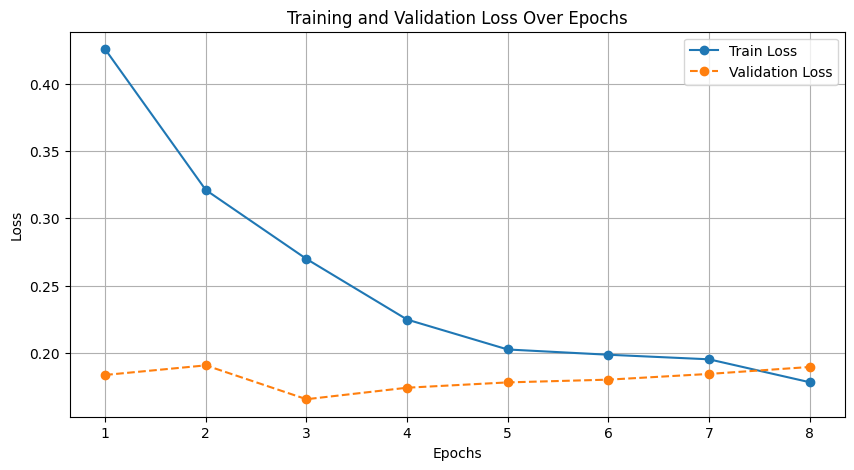

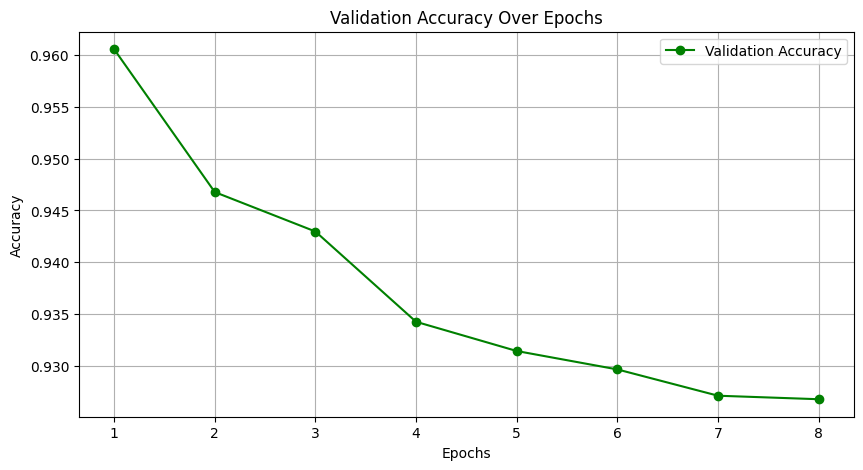

In [55]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(logs['train_loss_epoch']) + 1)
train_loss = logs['train_loss_epoch']
val_loss = logs['val_loss']
val_accuracy = logs['val_accuracy']


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


## Step 5: Plot Precision-Recall Curves for Different Classes

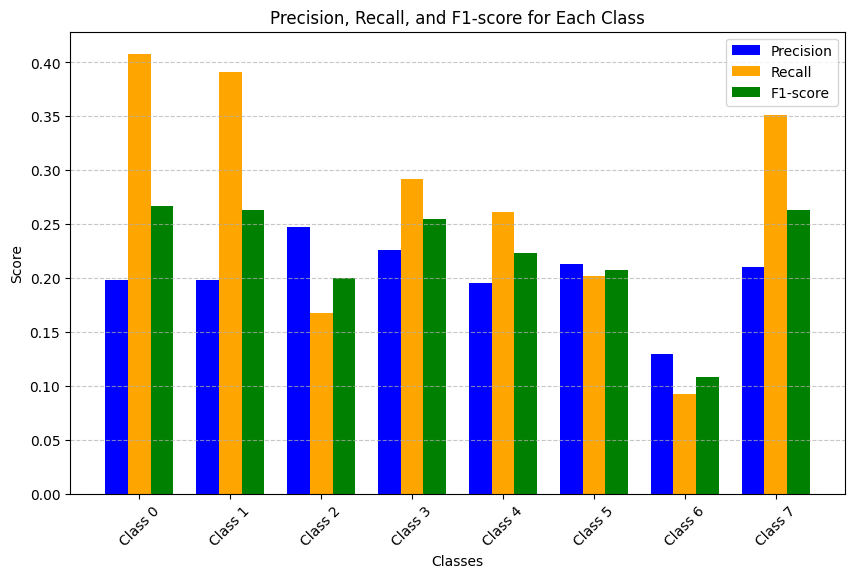

In [57]:
import matplotlib.pyplot as plt
import numpy as np


classes = report_df.index[:-4]  # （micro avg, macro avg, weighted avg, samples avg）
precision = report_df.loc[classes, "precision"].values
recall = report_df.loc[classes, "recall"].values
f1_score = report_df.loc[classes, "f1-score"].values


plt.figure(figsize=(10, 6))

#  Precision, Recall, F1-score
bar_width = 0.25
x = np.arange(len(classes))

plt.bar(x, precision, bar_width, label="Precision", color="blue")
plt.bar(x + bar_width, recall, bar_width, label="Recall", color="orange")
plt.bar(x + 2 * bar_width, f1_score, bar_width, label="F1-score", color="green")

plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score for Each Class")
plt.xticks(x + bar_width, classes, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


# Predict with model

In [58]:
def classify_raw_comments(model, dm):
    predictions = []
    model.eval()
    for batch in dm.val_dataloader():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        with torch.no_grad():
            _, logits = model(input_ids, attention_mask=attention_mask)  # Unpack loss and logits
            predictions.append(logits)
    flattened_predictions = torch.sigmoid(torch.cat(predictions, dim=0)).cpu().numpy()
    return flattened_predictions

In [59]:
predictions = classify_raw_comments(model, ucc_data_module)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
val_data = pd.read_csv(val_path)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')